# Assignment 2 - Mining Frequent Pattern and Asssociation Rules

**Import all libraries and load data here**

In [91]:
# This is a code cell
# -- Import all libraries and load data in this cell --

# data manipulation
import pandas as pd

# data visualization
import matplotlib.pyplot as plt

# record elapsed time
import time

# save text
import numpy as np

# association rule mining
from mlxtend.frequent_patterns import apriori as mlx_apriori
from efficient_apriori import apriori as eff_apriori

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Read "record.csv" as pandas DataFrame
df = pd.read_csv("record.csv")

# Print types of dirty records
print("Missing values count: ")
print(df.isnull().sum())
print("\nNegative Unitprice: %d"%(df.UnitPrice.loc[df.UnitPrice <= 0].count()))
print("\nWrong Stockcodes: %d"%(df.StockCode.str.match("[^0-9]").sum()))

Missing values count: 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64

Negative Unitprice: 2517

Wrong Stockcodes: 2995


## Section 1 - Data Cleaning and Exploration (20 points)

<span style="color:blue"> Please provide a description of each of the types of “dirty” records that you can find in the dataset, as well as the corresponding number of such records that are to be removed the dataset. Also, write down your code for removing those records. </span>

>**"Dirty" Records:** (There exists intersection parts of three types)<br>
-  Missing values: Description=1454, CustomerID=135080; <br>
-  Negative unitprices: 2517;<br>
-  Wrong StockCode (like "BANK CHARGES"): 2995.

In [92]:
# This is a code cell
# -- Your code for removing dirty records goes here --

# 1. Drop missing values
df.dropna(inplace=True)

# 2. Drop negative Unitprice
# Note that quantity can be negative because there are return services, i.e. StockCode 23843 has two transactions 
# with quantity of 80885 and -80885, so eventually not even one item-23843 is given out in the two transactions.
df = df[(df['UnitPrice']>0)]

# 3. Drop wrong stockcode like "BANK CHARGES"
df = df.loc[df.StockCode.str.match("^[0-9]")]

print("\n1-2.Starting date: {}; Ending date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))
print("3.Number of customers: %d"%(df.CustomerID.nunique()))
print("4.Number of transactions: %d"%(df.InvoiceNo.nunique()))
print("5.Number of items: %d"%(df.StockCode.nunique()))

# df_1 contains only CustomerID and unique InvoiceNo
df_1 = df[['CustomerID','InvoiceNo']]
df_1.drop_duplicates('InvoiceNo', keep='first', inplace=True)
series = df_1['CustomerID'].value_counts()
print("6.Number of transactions customer ID 17850 has made: %d"%(series[series.index  == 17850.0].data[0]))
print("7.Which customer (ID) has made the most transactions: ID %d"%(series.index[0]))

# df_2 contains only StockCode and Quantity
df_2 = df[['StockCode','Quantity']]
df_2 = df_2.groupby(['StockCode'], as_index=False)['Quantity'].sum()
print("8.What is the item ID of the best-seller: ID {}".format(df_2.StockCode[df_2.Quantity == df_2.Quantity.max()].tolist()[0]))



1-2.Starting date: 2010-12-01 08:26:00; Ending date: 2011-12-09 12:50:00
3.Number of customers: 4362
4.Number of transactions: 21785
5.Number of items: 3676
6.Number of transactions customer ID 17850 has made: 35
7.Which customer (ID) has made the most transactions: ID 14911
8.What is the item ID of the best-seller: ID 84077


<span style="color:blue"> 1)~8) Please provide the answers to the questions listed in the table. </span>

This is a markdown cell. Please fill in your answer for (1)~(8).

| No. | Question                                                                                                   | Answer       |
|-----|------------------------------------------------------------------------------------------------------------|--------------|
| 1)  | Starting date of the dataset?                                                                              | _2010-12-01_ |
| 2)  | Ending date of the dataset?                                                                                | _2011-12-09_ |
| 3)  | Number of customers?                                                                                       | _4362_ |
| 4)  | Number of transactions?                                                                                    | _21785_ |
| 5)  | Number of different kind of items?                                                                         | _3676_ |
| 6)  | Number of transactions customer ID 17850 has made?                                                         | 35 |
| 7)  | Which customer (ID) has made the most transactions?                                                        | _14911_ |
| 8)  | What is the item ID of the best-seller? We define "best-seller" as the item with the highest sales volume. | _84077_ |

<span style="color:blue"> 9) Next, let us get some general understanding about the transactions.  Please make a histogram of the number of unique items per transaction and describe one insight that you can observe from the plot, and explain why you find it interesting.  </span>

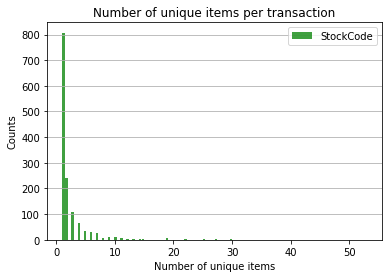

In [134]:
# This is a code cell
# --- Your code for generating the histogram goes here ---

df_3 = df[['InvoiceNo','StockCode',]].drop_duplicates(subset=["StockCode"]).groupby(["InvoiceNo"]).agg("count")
df_3.plot.hist(grid=False, bins=100, rwidth=.8, facecolor='g', alpha=0.75)
plt.title('Number of unique items per transaction')
plt.xlabel('Number of unique items')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=1)

>**Insights and reasons for (9):**
<br>There are more smaller number of unique items, mostly under 10. In another word, the majority of transactions happen when clients buy less than 10 kinds of items. 
 - I assume that's because there are more smaller transactions where clients only buy one or two books. This finding is interesting because it may help distinguish types of transactions

<span style="color:blue"> 10) We can also explore the data based on the items.  Let us make a bar plot of the items with support higher than 0.5%. Please describe one insight that you can observe from the plot, and explain how it can be related to rule mining. </span>

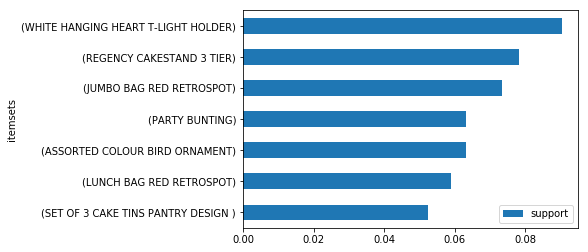

In [139]:
# This is a code cell
# --- Your code for generating the bar plot goes here ---

df_4 = df[["InvoiceNo","Description","Quantity"]]

basket = (df_4.groupby(["InvoiceNo","Description"])["Quantity"].sum() \
            .unstack().reset_index().fillna(0).set_index("InvoiceNo")) \
            .applymap(lambda x: 0 if x <= 0 else 1)

# Construct frequent itemset
freq_set = mlx_apriori(basket, min_support=0.05, use_colnames=True)
freq_set = freq_set.sort_values(["support"],ascending=True)
freq_set.plot.barh(x = 'itemsets',y = 'support')

>**Insights and reasons for (10)**:<br>
The item with highest support is "*White hanging heart t-light holder*". And all items have only one itemset. From the bar plot we can examine that support of itemsets with only one item is higher than(if not equal to) itemsets with more items.

<span style="color:blue"> 11) Compare the “best-seller” that you have previously found in (8) and the item with the highest support that you have just found in (10). Which item do you think is more popular? Here we define the “popular” items as items that are bought by many customers. Explain you answer and describe any assumptions you’ve made. </span>

>**Answer and explanations to (11):**<br>
The item found in (10) is more popular. 
- Because the item in (8) has highest sales volume, but here "popular" is defined by customer counts, which makes item in (10) more "popular".

## Section 2 - Mining Association Rules

<span style="color:blue"> 1) Will we complete the counting before the sun burns out (the sun has another $ 5 \times 10^9 < 2^{33} $ years to burn)? </span>

In [111]:
pow(3,3676)-pow(2,2677)+1 > pow(2,33)*365*24*3600*pow(2,36)

True

>**Answer and reasons for (1):**<br>
- Number of unique items = 3676<br>
Counts of brute-force method = 3^3676 - 2^(3676+1) + 1 > 365 \* 24 \* 3600 \* 2^33 \* 2^36<br>
Therefore, we will not complete counting before the sun burns out.

<span style="color:blue"> 2) Run efficient-apriori in python with min_support=0.5%, min_confidence=20%, max_length=4. Write down the rule with the highest lift (denoted as $r_1$). </span>

In [123]:
# This is a code cell
# --- Your code for apriori algorithm goes here ---

df_5 = df[["InvoiceNo","Description"]]
basket_set = df_5.groupby("InvoiceNo").Description.apply(tuple).tolist()
start = time.time()
itemsets_1, rules_1 = eff_apriori(basket_set, min_support=0.005, min_confidence = 0.2, max_length = 4)
count_time = time.time() - start
print('Time: ', count_time, 'seconds')

Time:  1033.3675129413605 seconds


In [153]:
print(*sorted(rules_1, key=lambda rule: -rule.lift)[0:6])
len(rules_1)

{DOLLY GIRL CHILDRENS CUP} -> {DOLLY GIRL CHILDRENS BOWL} (conf: 0.810, supp: 0.005, lift: 121.624, conv: 5.215) {DOLLY GIRL CHILDRENS BOWL} -> {DOLLY GIRL CHILDRENS CUP} (conf: 0.821, supp: 0.005, lift: 121.624, conv: 5.539) {HERB MARKER PARSLEY, HERB MARKER THYME} -> {HERB MARKER BASIL, HERB MARKER CHIVES } (conf: 0.820, supp: 0.006, lift: 120.666, conv: 5.511) {HERB MARKER BASIL, HERB MARKER CHIVES } -> {HERB MARKER PARSLEY, HERB MARKER THYME} (conf: 0.953, supp: 0.006, lift: 120.666, conv: 20.976) {REGENCY TEA PLATE GREEN , ROSES REGENCY TEACUP AND SAUCER } -> {GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE ROSES } (conf: 0.791, supp: 0.006, lift: 120.480, conv: 4.750) {GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE ROSES } -> {REGENCY TEA PLATE GREEN , ROSES REGENCY TEACUP AND SAUCER } (conf: 0.846, supp: 0.006, lift: 120.480, conv: 6.454)


4925

>**The rule you find for (2):**<br>
Rule with highest fit:<br> 
{DOLLY GIRL CHILDRENS CUP} -> {DOLLY GIRL CHILDRENS BOWL}<br>
{DOLLY GIRL CHILDRENS BOWL} -> {DOLLY GIRL CHILDRENS CUP}

<span style="color:blue"> 3) Run efficient-apriori in python with min_support=1%, min_confidence=20%, max_length=4. Write down the rule with the highest lift (denoted as $r_2$). </span>

In [140]:
# This is a code cell
# --- Your code for apriori algorithm goes here ---

start = time.time()
itemsets_2, rules_2 = eff_apriori(basket_set, min_support=0.01, min_confidence = 0.2, max_length = 4)
count_time = time.time() - start
print('Time: ', count_time, 'seconds')

Time:  274.4368782043457 seconds


In [154]:
print(*sorted(rules_2, key=lambda rule: -rule.lift)[0:6])
len(rules_2)

{SET/6 RED SPOTTY PAPER PLATES} -> {SET/6 RED SPOTTY PAPER CUPS} (conf: 0.726, supp: 0.011, lift: 55.506, conv: 3.604) {SET/6 RED SPOTTY PAPER CUPS} -> {SET/6 RED SPOTTY PAPER PLATES} (conf: 0.828, supp: 0.011, lift: 55.506, conv: 5.730) {REGENCY TEA PLATE ROSES } -> {REGENCY TEA PLATE GREEN } (conf: 0.682, supp: 0.011, lift: 54.055, conv: 3.108) {REGENCY TEA PLATE GREEN } -> {REGENCY TEA PLATE ROSES } (conf: 0.844, supp: 0.011, lift: 54.055, conv: 6.296) {POPPY'S PLAYHOUSE KITCHEN} -> {POPPY'S PLAYHOUSE BEDROOM } (conf: 0.731, supp: 0.012, lift: 49.898, conv: 3.658) {POPPY'S PLAYHOUSE BEDROOM } -> {POPPY'S PLAYHOUSE KITCHEN} (conf: 0.799, supp: 0.012, lift: 49.898, conv: 4.905)


525

>**The rule you find for (3):**<br>
Rule with highest fit:<br> 
{SET/6 RED SPOTTY PAPER PLATES} -> {SET/6 RED SPOTTY PAPER CUPS}<br>
{SET/6 RED SPOTTY PAPER CUPS} -> {SET/6 RED SPOTTY PAPER PLATES}

<span style="color:blue"> 4) Run efficient-apriori in python with min_support=0.5%, min_confidence=40%, max_length=4. Write down the rule with the highest lift (denoted as $r_3$). </span>

In [143]:
# This is a code cell
# --- Your code for apriori algorithm goes here ---

start = time.time()
itemsets_3, rules_3 = eff_apriori(basket_set, min_support=0.005, min_confidence = 0.4, max_length = 4)
count_time = time.time() - start
print('Time: ', count_time, 'seconds')

Time:  1048.9448318481445 seconds


In [155]:
print(*sorted(rules_3, key=lambda rule: -rule.lift)[0:6])
len(rules_3)

{DOLLY GIRL CHILDRENS CUP} -> {DOLLY GIRL CHILDRENS BOWL} (conf: 0.810, supp: 0.005, lift: 121.624, conv: 5.215) {DOLLY GIRL CHILDRENS BOWL} -> {DOLLY GIRL CHILDRENS CUP} (conf: 0.821, supp: 0.005, lift: 121.624, conv: 5.539) {HERB MARKER PARSLEY, HERB MARKER THYME} -> {HERB MARKER BASIL, HERB MARKER CHIVES } (conf: 0.820, supp: 0.006, lift: 120.666, conv: 5.511) {HERB MARKER BASIL, HERB MARKER CHIVES } -> {HERB MARKER PARSLEY, HERB MARKER THYME} (conf: 0.953, supp: 0.006, lift: 120.666, conv: 20.976) {REGENCY TEA PLATE GREEN , ROSES REGENCY TEACUP AND SAUCER } -> {GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE ROSES } (conf: 0.791, supp: 0.006, lift: 120.480, conv: 4.750) {GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE ROSES } -> {REGENCY TEA PLATE GREEN , ROSES REGENCY TEACUP AND SAUCER } (conf: 0.846, supp: 0.006, lift: 120.480, conv: 6.454)


2774

>**The rule you find for (4):**<br>
Rule with highest fit:<br>
{DOLLY GIRL CHILDRENS CUP} -> {DOLLY GIRL CHILDRENS BOWL}<br>
{DOLLY GIRL CHILDRENS BOWL} -> {DOLLY GIRL CHILDRENS CUP}

<span style="color:blue"> 5) You must have noticed numerous differences between the two runs in (2) and (3). List at least 3 differences you’ve found. You may want to consider the elapsed time and the quality of the results.  </span>

>**The differences you find in (5):**<br>
- elaspsed time: r1(1033s) > r2(274s);<br>
- r1 has more itemsets records: r1(4925) > r2(525);<br>
- r2 has higher fit than r1.

<span style="color:blue"> 6) Which one in $r_1$,$r_2$, and $r_3$ do you think is better? Explain your answer. </span>

>**Answer and reasons for (6):**<br>
I think **r3** is the best. <br>
- 
Though it cost more time, its lift & min_confidence are the highest. So r3 is the best of three.

<span style="color:blue"> 7) From your observation, what are the effects of increasing/reducing min_support and min_confidence? Support your answer with evidence. </span>

>**Answer and evidences for (7):**<br>
1) The reduce of min_support (increase of min_confidence) will increase elapsed time. <br>
 **Evidence:** *r3.supp $\approx$ r2.supp > r1.supp **==>** r3.time(1048s) > r1.time(1033) > r2.time(274s)*<br>
2) The reduce of min_support (increase of min_confidence) will result in better performance<br>
 **Evidence:** *r3.supp $\approx$ r2.supp > r1.supp **==>** r3.fit > r1.fit > r2.fit*<br>

## Section 3 - Mining Sequential Rules

<span style="color:blue"> 1) Organize the dataset into sequences and fill the table below. </span>

In [105]:
# Encode StockCode into integer 1-3676
df_6 = df
df_6 = df_6.assign(IntCode = lambda x: x.StockCode.astype('category').cat.codes+1)
df_6.to_csv("IntStockCode.csv")

In [113]:
# "df2.csv" is generated by R since it is easier to change format in R
my_df = pd.read_csv("mydf.csv")
my_df.head(10)

,Unnamed: 0,CustomerID,items1
0,1,12346,2002 -1 2002
1,2,12347,3248 1251 2659 1357 1625 1626 1627 1628 1629 1...
2,3,12348,3142 1798 3141 3141 427 427 1474 917 918 754 4...
3,4,12349,1948 2272 646 556 645 1033 1091 2631 3132 1683...
4,5,12350,876 1282 2734 2751 1228 2816 1412 1417 824 882...
5,6,12352,534 968 440 1504 1633 1293 1511 1024 773 774 7...
6,7,12353,2509 2506 1738 2510
7,8,12354,2036 2039 2040 2087 2088 2089 886 1689 443 314...
8,9,12355,1548 1916 1917 1738 1506 1293 3194 1554 1552 1...
9,10,12356,1040 413 362 414 439 964 966 970 1034 1033 109...


In [114]:
# Generate input file for SPMF
SPMF_input = my_df.items1 + " -2"
SPMF_input.to_csv("input.csv", index=False)

In [19]:
# For the markdown cell below (The sequential data above does not include time and transaction counts)
print("Beginning Date of Sequence:",df[df.CustomerID == 12356].InvoiceDate.min())
print("Ending Date of Sequence:",df[df.CustomerID == 12356].InvoiceDate.max())
print("Number of transactions in the sequence:",series[series.index == 12356.0].data[0])

Beginning Date of Sequence: 2011-01-18 09:50:00
Ending Date of Sequence: 2011-11-17 08:40:00
Number of transactions in the sequence: 3


This is a markdown cell. Please fill in your answer for (1).

| CustomerID | Beginning Date of Sequence | Ending Date of Sequence | Number of transactions in the sequence |
|:----------:|:--------------------------:|:-----------------------:|:--------------------------------------:|
|    12356   |        _2011-01-18_        |       _2011-11-17_      |              3              |

<span style="color:blue"> 2) Run ERMiner with min_support=0.5%, min_confidence=60%, maximum length of antecedent and consequence being 1. Write down the rule(s) with the highest confidence. </span> You need to convert the dataset into the format that SPMF supports. Please read http://www.philippe-fournier-viger.com/spmf/ERMiner.php carefully.

In [115]:
# Retrieved results from SPMF
result = pd.read_csv('output.txt', sep=" ", header=None)
result.columns = ["First", "","Second", "Support", "a","Confidence","b"]
result.sort_values('b',ascending=False)

,First,,Second,Support,a,Confidence,b
0,1094,==>,1093,#SUP:,31,#CONF:,0.720930
2,1699,==>,1697,#SUP:,46,#CONF:,0.676471
1,1583,==>,1581,#SUP:,105,#CONF:,0.636364
6,1711,==>,3250,#SUP:,24,#CONF:,0.631579
3,1848,==>,1844,#SUP:,22,#CONF:,0.628571
8,3267,==>,173,#SUP:,22,#CONF:,0.628571
7,3047,==>,3250,#SUP:,25,#CONF:,0.625000
5,1655,==>,3250,#SUP:,124,#CONF:,0.620000
4,2790,==>,394,#SUP:,39,#CONF:,0.609375


In [118]:
print(df_6.loc[df_6.IntCode == 1094].head(1).Description)
print(df_6.loc[df_6.IntCode == 1093].head(1).Description)

222    LARGE POPCORN HOLDER 
Name: Description, dtype: object
221    SMALL POPCORN HOLDER
Name: Description, dtype: object


>**The rule(s) you find for (2):**<br>
- LARGE POPCORN HOLDER --> SMALL POPCORN HOLDER

<span style="color:blue"> 3) Do you think the parameters used in (2) are good in practice? If yes, explain your answer. If no, give a better set of parameters and explain why it is better. </span>

In [121]:
# Retrieved results from SPMF: min_support = 0.2%, min_confidence  = 60%
result1 = pd.read_csv('~/Desktop/output.txt', sep=" ", header=None)
result1.columns = ["First", "","Second", "Support", "a","Confidence","b"]
result1.sort_values('b',ascending=False).head(5)

,First,,Second,Support,a,Confidence,b
28,674,==>,1293,#SUP:,9,#CONF:,0.900000
40,2616,==>,173,#SUP:,9,#CONF:,0.900000
41,2616,==>,1258,#SUP:,9,#CONF:,0.900000
62,3201,==>,3070,#SUP:,9,#CONF:,0.818182
74,577,==>,3250,#SUP:,11,#CONF:,0.733333


>**Your answer for (3):**<br>
Not good enough
- Explain: Min support can be set lower to mine sequential rules with more significant confidence. Min support being 0.2% is legit since 0.2% is still a lot considering our large sequential data. And when I change min_support to 0.2%, I got better confidence results. 

<span style="color:blue"> 4) What are the differences between sequential rules and association rules? Give 2 of them. Describe a circumstance where sequential rules apply but association rules do not. </span>

<img src="http://www.philippe-fournier-viger.com/spmf/map_algorithms_spmf_data_mining097.png">

**Your answer for (4):**<br> 
I retrieved the above picture on SPMF website as a reference.<br>
<div class="alert alert-block alert-warning">
<b>Difference:</b>
- **Input data form:** <br>
 - Association: a transaction database <br>
 - Sequential: a sequence database
- **The goal:**<br>
 - Association: to find sets of items that appear often in transactions, without considering a sequential ordering such as time<br>
 - Sequential: to discover subsequences that appear often in a set of sequences, where the sequential ordering between items is considered
</div>
**Circumstance:**<br>
When there is a sequential ordering in the data, we should use sequential rule mining instead of association rules.